In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as scq

import numpy as np

# All-in-one

In [2]:
# parameters for the flux qubit
RATIO = 60.0
ALPHA = 0.8

flux_qubit = scq.CircuitFluxQubit(
    EJ1 = 1.0, 
    EJ2 = 1.0, 
    EJ3 = ALPHA*1.0, 
    ECJ1 = 1.0/RATIO, 
    ECJ2 = 1.0/RATIO, 
    ECJ3 = 1.0/ALPHA/RATIO, 
    ECg1 = 50.0/RATIO, 
    ECg2 = 50.0/RATIO, 
    ng1 = 0.0, 
    ng2 = 0.0, 
    flux = 0.4, 
    ncut = 10,
)

# Eigenvalues and eigensystem using scqubit tools

(<Figure size 750x750 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x21599e24490>)

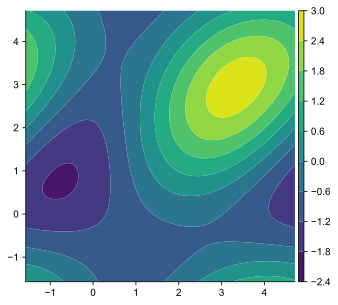

In [3]:
flux_qubit.plot_potential()

In [4]:
vals, vecs= flux_qubit.eigensys()

In [5]:
vals
#vecs_phase = np.conj(unitary).T@vecs
vals - vals[0]

array([0.        , 0.26299666, 0.29339598, 0.50146767, 0.55310417,
       0.57154646])

# Eigenvalues using circuit tools

In [6]:
flux_qubit.calculate_potentials()
vals, vecs = flux_qubit.diagonalize_phase(num_states=6)

In [7]:
np.real(vals-vals[0])

array([0.        , 0.26299666, 0.29339598, 0.50146767, 0.55310417,
       0.57154646])

In [8]:
vecs.shape

(21, 21, 1, 1, 1, 6)

1.000000000000013

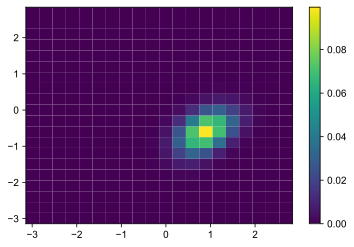

In [9]:
import matplotlib.pyplot as plt
vecs = np.reshape(vecs, (2*flux_qubit.ncut+1,2*flux_qubit.ncut+1,6))
plt.pcolormesh(flux_qubit.phi1.get_phase_grid(), flux_qubit.phi2.get_phase_grid(), np.abs(vecs[:,:,0])**2)
plt.colorbar()
np.sum(np.abs(vecs[:,:,0])**2)

# Defining circuit topology

In [10]:
flux_qubit = scq.Circuit()
flux_qubit.add_element(scq.Capacitance('Cg1'), ['g1', '1'])
flux_qubit.add_element(scq.Capacitance('Cg2'), ['g2', '2'])
flux_qubit.add_element(scq.Capacitance('CJ1'), ['GND', '1'])
flux_qubit.add_element(scq.Capacitance('CJ2'), ['GND', '2'])
flux_qubit.add_element(scq.Capacitance('CJ3'), ['1', '3'])
flux_qubit.add_element(scq.JosephsonJunction('J1', use_offset=False), ['GND', '1'])
flux_qubit.add_element(scq.JosephsonJunction('J2', use_offset=False), ['GND', '2'])
flux_qubit.add_element(scq.JosephsonJunction('J3', use_offset=False), ['1', '3'])

# Parametrizing Hamiltonian

In [11]:
ϕ1 = scq.Variable('ϕ_1')
ϕ2 = scq.Variable('ϕ_2')
f =  scq.Variable('f')
g1 = scq.Variable('g_1')
g2 = scq.Variable('g_2')

flux_qubit.add_variable(ϕ1)
flux_qubit.add_variable(ϕ2)
flux_qubit.add_variable(f)
flux_qubit.add_variable(g1)
flux_qubit.add_variable(g2)

# Mapping nodal phases to variables

In [12]:
flux_qubit.map_nodes_linear(['GND', '1', '2', '3', 'g1', 'g2'],
                            ['ϕ_1', 'ϕ_2', 'f', 'g_1', 'g_2'],
                            np.asarray([[0,   0,   0,   0,   0],
                                        [1,   0,   0,   0,   0],
                                        [0,   1,   0,   0,   0],
                                        [0,   1,  -1,   0,   0],
                                        [0,   0,   0,   1,   0],
                                        [0,   0,   0,   0,   1]]))

# Separating variables into external controls and degrees of freedom

In [13]:
ϕ1.set_variable(21, 1) # 21 charge states, 2pi wavefunction periodicity
ϕ2.set_variable(21, 1) # 21 charge states, 2pi wavefunction periodicity
f.set_parameter(0.4*2*np.pi, 0) # external flux: 0.4 quantum, external voltage: 0
g1.set_parameter(0, 0) # external flux: 0 quanta, external voltage: 0
g2.set_parameter(0, 0) # external flux: 0 quanta, external voltage: 0

# Printing symbolic Hamiltonian (using sympy)
This part is a bit ugly, but in principle we could improve it so it uses better notation

In [14]:
import sympy
C_g1, C_g2, C_J1, C_J2, C_J3, E_J1, E_J2, E_J3 = \
    sympy.symbols('C_g1, C_g2, C_J1, C_J2, C_J3, E_J1, E_J2, E_J3')
flux_qubit.find_element('Cg1').set_capacitance(C_g1)
flux_qubit.find_element('Cg2').set_capacitance(C_g2)
flux_qubit.find_element('CJ1').set_capacitance(C_J1)
flux_qubit.find_element('CJ2').set_capacitance(C_J2)
flux_qubit.find_element('CJ3').set_capacitance(C_J3)
flux_qubit.find_element('J1').set_critical_current(E_J1)
flux_qubit.find_element('J2').set_critical_current(E_J2)
flux_qubit.find_element('J3').set_critical_current(E_J3)

## capacitance matrix in terms of the nodal parameterization

In [15]:
flux_qubit.capacitance_matrix(symbolic=True)

Matrix([
[C_J1 + C_J2,   0.0,              -C_J1,   0.0,       -C_J2,   0.0],
[        0.0,  C_g1,              -C_g1,   0.0,         0.0,   0.0],
[      -C_J1, -C_g1, C_J1 + C_J3 + C_g1,   0.0,         0.0, -C_J3],
[        0.0,   0.0,                0.0,  C_g2,       -C_g2,   0.0],
[      -C_J2,   0.0,                0.0, -C_g2, C_J2 + C_g2,   0.0],
[        0.0,   0.0,              -C_J3,   0.0,         0.0,  C_J3]])

## Legendre transform of the capacitance matrix (inverse wrt to degrees of freedom)

In [16]:
flux_qubit.capacitance_matrix_legendre_transform(symbolic=True)

Matrix([
[                                                                                                               (C_J2 + C_J3 + C_g2)/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2),                                                                                                                                 C_J3/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2),                                                                                                                                                                                                                                                      C_J3**2/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2) - C_J3*(C_J2 + C_J3 + C_g2)/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2),                                                          

## Symbolic lagrangian

In [17]:
sympy.nsimplify(flux_qubit.symbolic_lagrangian())

E_J1*cos(ϕ_1) + E_J2*cos(ϕ_2) + E_J3*cos(f + ϕ_1 - ϕ_2) + \partial_tg_1*(C_g1*\partial_tg_1/2 - C_g1*\partial_tϕ_1/2) + \partial_tg_2*(C_g2*\partial_tg_2/2 - C_g2*\partial_tϕ_2/2) + \partial_tϕ_1*(-C_J3*(-\partial_tf/2 + \partial_tϕ_2/2) - C_g1*\partial_tg_1/2 + \partial_tϕ_1*(C_J1 + C_J3 + C_g1)/2) + \partial_tϕ_2*(-C_g2*\partial_tg_2/2 + \partial_tϕ_2*(C_J2 + C_g2)/2) + (-\partial_tf + \partial_tϕ_2)*(-C_J3*\partial_tϕ_1/2 + C_J3*(-\partial_tf/2 + \partial_tϕ_2/2))

## Symbolic hamiltonian

In [18]:
sympy.nsimplify(flux_qubit.symbolic_hamiltonian())

-E_J1*cos(ϕ_1) - E_J2*cos(ϕ_2) - E_J3*cos(f + ϕ_1 - ϕ_2) + \partial_tf*(\partial_tf*(C_J3*(-C_J3**2/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2) + C_J3*(C_J2 + C_J3 + C_g2)/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2)) - C_J3*(C_J3**2/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2) - C_J3*(C_J1 + C_J3 + C_g1)/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2))) + \partial_tg_1*(C_J3**2*C_g1/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2) - C_J3*C_g1*(C_J2 + C_J3 + C_g2)/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2)) + \partial_tg_2*(-C_J3**2*C_g2/(C_J1*C_J2 + C_J1*C_J3 + C_J1*C_g2 + C_J2*C_J3 + C_J2*C_g1 + C_J3*C_g1 + C_J3*C_g2 + C_g1*C_g2) + C_J3*C_g2*(C_J1 + C_J3 + C_g1)/(C_J1*C_J2 + C_J1*C_J3 + 